In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/pdm dataset/project_dataset')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [ ]:
dataset =  pd.read_csv("PdM_telemetry.csv")
machines_dfs = {}

In [ ]:
dataset.head()

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


In [ ]:
machines = dataset["machineID"].unique()
for machine in machines:
  machines_dfs[machine] = {}
  machines_dfs[machine]["telemetry"] = dataset.loc[dataset['machineID'] == machine].drop(["datetime","machineID"], axis=1)
  machines_dfs[machine]["no_sensors"] = machines_dfs[machine]["telemetry"].shape[1]

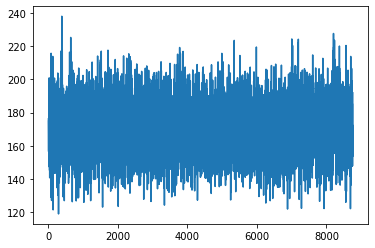

In [ ]:
plt.plot(machines_dfs[1]["telemetry"]["volt"][:])

#Model

In [ ]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.model_selection import GridSearchCV
from keras.callbacks import ModelCheckpoint
import matplotlib.dates as mdates
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.losses as loss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
look_back = 20

In [ ]:
def telemetry_prep(telemetry_df,look_back):
  scaler = MinMaxScaler(feature_range=(0,1))
  normalized_data = scaler.fit_transform(telemetry_df)
  data_x = []
  data_y = []
  for i in range(0,len(normalized_data)-look_back):
    data_x.append(normalized_data[i:i+ look_back, 0:dataset.shape[1]])
    data_y.append(normalized_data[i+ look_back, 0:dataset.shape[1]].flatten())

  return np.array(data_x), np.array(data_y)

In [ ]:
# for machine in machines_dfs:

train_x, train_y = telemetry_prep(machines_dfs[30]["telemetry"][200:],look_back)

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model=Sequential()
model.add(LSTM(15,activation='tanh', return_sequences=True ,input_shape=(look_back,4)))
model.add(LSTM(10,activation='tanh' ))

model.add(Dropout(0.2))
model.add(Dense(4))


#Model summary
model.summary()

#Compiling
model.compile(optimizer=opt, loss = "mse")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 15)            1200      
                                                                 
 lstm_1 (LSTM)               (None, 10)                1040      
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 dense (Dense)               (None, 4)                 44        
                                                                 
Total params: 2,284
Trainable params: 2,284
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history=model.fit(train_x, train_y, epochs = 1500, batch_size=100, validation_split=.2)

Epoch 1/1500
140/140 [==============================] - 17s 38ms/step - loss: 0.0491 - val_loss: 0.0151
Epoch 2/1500
140/140 [==============================] - 3s 24ms/step - loss: 0.0243 - val_loss: 0.0151
Epoch 3/1500
140/140 [==============================] - 3s 21ms/step - loss: 0.0221 - val_loss: 0.0149
Epoch 4/1500
140/140 [==============================] - 3s 22ms/step - loss: 0.0206 - val_loss: 0.0148
Epoch 5/1500
140/140 [==============================] - 3s 25ms/step - loss: 0.0192 - val_loss: 0.0149
Epoch 6/1500
140/140 [==============================] - 4s 28ms/step - loss: 0.0184 - val_loss: 0.0147
Epoch 7/1500
140/140 [==============================] - 3s 21ms/step - loss: 0.0176 - val_loss: 0.0145
Epoch 8/1500
140/140 [==============================] - 3s 21ms/step - loss: 0.0168 - val_loss: 0.0145
Epoch 9/1500
140/140 [==============================] - 3s 21ms/step - loss: 0.0161 - val_loss: 0.0144
Epoch 10/1500
140/140 [==============================] - 4s 31ms/step - 

In [ ]:
train_x[150]

array([[0.37658432, 0.61697833, 0.36355805, 0.67945262],
       [0.49424059, 0.53657432, 0.41091507, 0.60369581],
       [0.53996034, 0.64672114, 0.52945427, 0.74955229],
       [0.33559064, 0.55628477, 0.49426042, 0.67402333],
       [0.60455719, 0.44515612, 0.35861827, 0.56755119],
       [0.47334507, 0.69319996, 0.51896878, 0.64121589],
       [0.51478997, 0.45495977, 0.56677666, 0.60120792],
       [0.31544863, 0.67366563, 0.2300745 , 0.89798506],
       [0.31332388, 0.43837478, 0.57034032, 0.6125674 ],
       [0.4229088 , 0.56830598, 0.58348534, 0.66106203],
       [0.55331313, 0.52647992, 0.5547507 , 0.62798514],
       [0.61172203, 0.54823908, 0.35762415, 0.56797873],
       [0.33935327, 0.69727822, 0.57889605, 0.50627306],
       [0.78497701, 0.67338994, 0.45388642, 0.66382625],
       [0.64486183, 0.57225735, 0.3049118 , 0.72485863],
       [0.58672618, 0.59031785, 0.45848935, 0.6917406 ],
       [0.22759351, 0.63053205, 0.28261668, 0.72266349],
       [0.57342409, 0.55770208,

In [ ]:
test_x, test_y = telemetry_prep(machines_dfs[30]["telemetry"],look_back)
prediction = test_x[150:151]
input_data = prediction
for i in range(10):
  y_pred=model.predict(input_data)
  input_data = np.delete(input_data,0,axis=1)
  input_data = np.append(input_data,[y_pred],axis=1)
  prediction = np.append(prediction,[y_pred],axis=1)


1/1 [==============================] - 0s 60ms/step


In [ ]:
# np.delete(train_x[150:151],0,axis=1)
# np.append(train_x[150:151],[np.array([[0.48660937, 0.5597176 , 0.47429535, 0.63642925]])],axis=1)

In [ ]:
y_pred

array([[0.47364026, 0.62940013, 0.4793258 , 0.61224777]], dtype=float32)

In [ ]:
train_x[150:151,:,3][0]

array([0.67945262, 0.60369581, 0.74955229, 0.67402333, 0.56755119,
       0.64121589, 0.60120792, 0.89798506, 0.6125674 , 0.66106203,
       0.62798514, 0.56797873, 0.50627306, 0.66382625, 0.72485863,
       0.6917406 , 0.72266349, 0.64537574, 0.52906646, 0.6225306 ])

In [ ]:
prediction[:,:,3]

array([[0.67945262, 0.60369581, 0.74955229, 0.67402333, 0.56755119,
        0.64121589, 0.60120792, 0.89798506, 0.6125674 , 0.66106203,
        0.62798514, 0.56797873, 0.50627306, 0.66382625, 0.72485863,
        0.6917406 , 0.72266349, 0.64537574, 0.52906646, 0.6225306 ,
        0.66782761, 0.66541213, 0.72031593, 0.73218054, 0.78207839,
        0.59556067, 0.73271245, 0.73793006, 0.56383443, 0.61224777]])

In [ ]:
  normalizer = MinMaxScaler(feature_range=(0,1))
  normalized_data = normalizer.fit_transform(machines_dfs[30]["telemetry"])

In [ ]:
normalized_data

array([[0.57570438, 0.53264443, 0.38613907, 0.42998372],
       [0.35430488, 0.65037059, 0.36235374, 0.2787271 ],
       [0.24191758, 0.48124491, 0.49381064, 0.36823145],
       ...,
       [0.67228775, 0.48610986, 0.49535926, 0.68047548],
       [0.53340242, 0.43591645, 0.35839424, 0.43451753],
       [0.60831642, 0.50196198, 0.57338909, 0.45015475]])

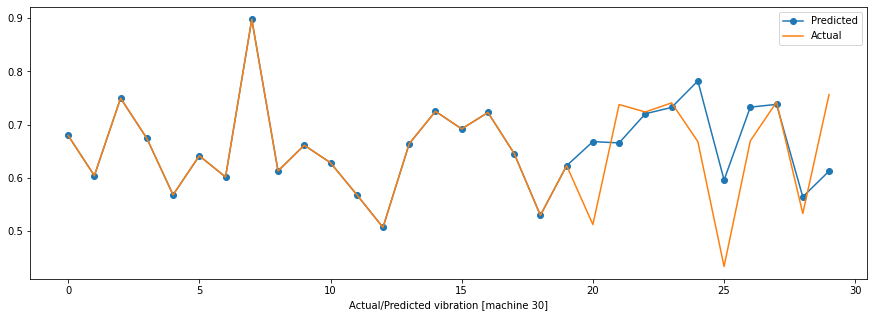

In [ ]:
x_data = range(100)
plt.figure(figsize=(15 , 5))
plt.plot(prediction[:,:,3][0] ,label='Predicted' ,marker='o')
plt.plot(normalized_data[150:180,3],label='Actual')
plt.xlabel("Actual/Predicted vibration [machine 30]")
plt.legend()
plt.show()

In [ ]:
model.save("lstm_1500_50.h5")